In [1]:
import os
from glob import glob
import tensorflow as tf

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model, Input
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from keras.layers import Dense, Dropout, Input, Concatenate, Average

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data_dir=r"dataset/valid"
skin=[]
for file in os.listdir(data_dir):
    skin+=[file]
print(skin)
print(len(skin))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
7


In [3]:
train_datagen= ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.4,
                height_shift_range=0.4,
                shear_range=0.2,
                zoom_range=0.2,
                fill_mode="nearest",
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1./255,
                preprocessing_function=None)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
                    'dataset/train',
                    target_size=(224, 224),
                    color_mode='rgb',
                    shuffle=True,
                    batch_size=16)

validation_generator = test_datagen.flow_from_directory(
                    'dataset/valid',
                    target_size=(224, 224),
                    color_mode='rgb',
                    batch_size=16)

Found 8512 images belonging to 7 classes.
Found 1503 images belonging to 7 classes.


In [4]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [5]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Define VGG16

In [6]:
vgg = VGG16(input_shape=(224,224, 3), include_top=False,weights = 'imagenet')

In [7]:
for layers in (vgg.layers):
    layers.trainable = False

In [8]:
vgg_model = Sequential()

vgg_model.add(vgg)
# Add new layers
vgg_model.add(Flatten())
vgg_model.add(Dense(512 , activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(7, activation='softmax'))

In [9]:
vgg_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['accuracy',precision,recall,sensitivity,specificity])

C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [10]:
vgg_model.load_weights("NEW models/Vgg16.h5")

In [11]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 27,563,847
Trainable params: 12,849,159
Non-trainable params: 14,714,688
_________________________________________________________________


## Define InceptionV3

In [12]:
pre_trained_model = InceptionV3(input_shape=(224, 224, 3),
include_top=False, weights="imagenet")
pre_trained_model.summary()
for layer in pre_trained_model.layers:
 layer.trainable=False

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [13]:
inception_model=Sequential()
inception_model.add(pre_trained_model)
inception_model.add(Flatten())
inception_model.add(Dense(256,activation='relu'))
inception_model.add(Dropout(0.4))
inception_model.add(Dense(7,activation='softmax'))

In [14]:
from keras.optimizers import Adam,SGD,Nadam,RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                    decay_steps=1000,
                                    decay_rate=0.6)
def schedule(epoch,lr):
    if epoch <=2 :
        return lr
    elif epoch > 2 and epoch <=4 :
        return lr/2
    elif epoch > 4 and epoch < 7 :
        return lr/3
    else:
        return lr/4

optimizer1 = Adam(learning_rate = 0.014)
optimizer2 = SGD(learning_rate = lr_schedule)
optimizer3 = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.4)
optimizer4 = Nadam(learning_rate=0.002)

cb1 = EarlyStopping(monitor='val_loss', patience = 10)
cb2 = tf.keras.callbacks.LearningRateScheduler(schedule,verbose=1)

model_checkpoint_callback = ModelCheckpoint(
                                    filepath='inceptionV3.h5',
                                    save_weights_only=True,
                                    monitor='val_acc',
                                    mode='max',
                                    save_best_only=True)

In [15]:
inception_model.compile(optimizer=optimizer2,
              loss='categorical_crossentropy',
              metrics =['accuracy',precision,recall,sensitivity,specificity])

In [16]:
inception_model.load_weights("NEW models/InceptionV3.h5")

In [17]:
inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 34,912,039
Trainable params: 13,109,255
Non-trainable params: 21,802,784
_________________________________________________________________


## Define ResUNet

In [18]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [20]:
def ResUNet50(shape = (224, 224, 3), classes = 7):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResUNet50")
    return model
# model.summary()

In [21]:
use_multiprocessing=True

In [22]:
resunet_model = ResUNet50(shape=(224, 224, 3))
resunet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',precision,recall,sensitivity,specificity])

In [23]:
resunet_model.load_weights("NEW models/resUnet.h5")

In [24]:
resunet_model.summary()

Model: "ResUNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 115, 115, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                          

                                                                                                  
 add_3 (Add)                    (None, 29, 29, 128)  0           ['batch_normalization_102[0][0]',
                                                                  'conv2d_103[0][0]']             
                                                                                                  
 activation_102 (Activation)    (None, 29, 29, 128)  0           ['add_3[0][0]']                  
                                                                                                  
 conv2d_104 (Conv2D)            (None, 29, 29, 128)  147584      ['activation_102[0][0]']         
                                                                                                  
 batch_normalization_103 (Batch  (None, 29, 29, 128)  512        ['conv2d_104[0][0]']             
 Normalization)                                                                                   
          

 conv2d_114 (Conv2D)            (None, 15, 15, 256)  590080      ['activation_111[0][0]']         
                                                                                                  
 batch_normalization_112 (Batch  (None, 15, 15, 256)  1024       ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_8 (Add)                    (None, 15, 15, 256)  0           ['batch_normalization_112[0][0]',
                                                                  'activation_110[0][0]']         
                                                                                                  
 activation_112 (Activation)    (None, 15, 15, 256)  0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_11

 activation_121 (Activation)    (None, 8, 8, 512)    0           ['batch_normalization_121[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 8, 8, 512)    2359808     ['activation_121[0][0]']         
                                                                                                  
 batch_normalization_122 (Batch  (None, 8, 8, 512)   2048        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_125 (Conv2D)            (None, 8, 8, 512)    131584      ['activation_120[0][0]']         
                                                                                                  
 add_13 (Add)                   (None, 8, 8, 512)    0           ['batch_normalization_122[0][0]',
          

## Define Ensemble Model

In [25]:
model_input = Input(shape=(224,224,3))

In [28]:
def ensemble(models, model_input):
    outputs = [model(model_input) for model in models]
    y = Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

In [29]:
ensemble_model = ensemble([vgg_model, inception_model, resunet_model], model_input)

In [30]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,sensitivity,specificity])

In [31]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

## Testing

In [33]:
loss, accuracy, precision, recall, sensitivity, specificity=ensemble_model.evaluate(validation_generator, verbose=1, steps=STEP_SIZE_VALID)

93/93 [==============================] - 562s 6s/step - loss: 0.6139 - accuracy: 0.7816 - precision: 0.8675 - recall: 0.6909 - sensitivity_at_specificity: 0.9980 - specificity_at_sensitivity: 1.0000


In [34]:
print("Validation: loss = %f  ;  Validation: accuracy = %f" % (loss, accuracy))
print("Precision = %f  ;  Recall = %f" % (precision, recall))
print("Sensitivity = %f  ;  Specificity = %f" % (sensitivity, specificity))

Validation: loss = 0.613882  ;  Validation: accuracy = 0.781586
Precision = 0.867511  ;  Recall = 0.690860
Sensitivity = 0.997984  ;  Specificity = 1.000000


1/1 [==============================] - 3s 3s/step
[0.04582457 0.12190044 0.66824174 0.00641362 0.07757544 0.0791565
 0.00088767]


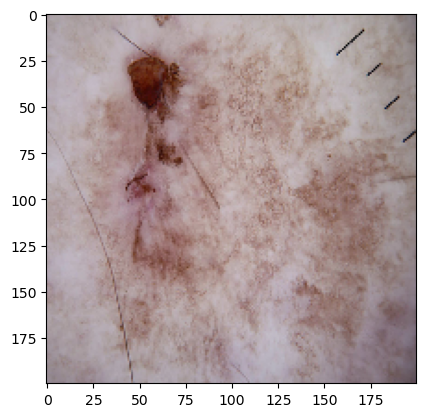

Prediction: bkl


In [35]:
from skimage import io
from tensorflow.keras.preprocessing import image

img = image.load_img(r'dataset\valid\bkl\ISIC_0025867.jpg', grayscale=False, target_size=(224,224))
show_img=image.load_img(r'dataset\valid\bkl\ISIC_0025867.jpg', grayscale=False, target_size=(200, 200))
skin = skin
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = ensemble_model.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skin[ind])